# Задача по максимизации экономической прибыли

Задача: максимизировать экономическую прибыль.

В таблице по ссылке приведены данные по займам, а также значения факторов.

Необходимо построить скоринговую модель, которая позволит максимизировать совокупную экономическую прибыль (в процентах от суммы выдачи). Скоринговая модель получает на вход значения факторов, на выходе выдает ответ, нужно ли выдавать данный заем.

Значение экономической прибыли считается следующим образом:

Loss = Unpaid * (EL, expected loss)  
InvestorProfit = Earned — Loss  
Profit = InvestorProfit + Commission  
Profit% = Profit / LoanIssued  

Задача модели состоит в том, чтобы выдавать на основе факторов займы таким образом, чтобы % экономической прибыли был максимальным.

В качестве ответа необходимо:

- написать скрипт, решающий данную задачу
- подробно описать ход решения
- предложить интерпретацию решения — какие именно факторы нужно изменить и почему

## Предобработка данных о займах

In [29]:
# импорт библиотек
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import lightgbm as lgb

In [2]:
# импорт данных о займах
loans = pd.read_excel('ТЗ аналитик данных.xlsx', usecols='A:F', skiprows=1)

# заменим название столбцов на более удобные
loans.columns = ['loan_issued', 'rating', 'comission', 'earned_int', 'unpaid', 'EL']
loans

,loan_issued,rating,comission,earned_int,unpaid,EL
0,3 170 000 ₽,7,0.0530,211 051 ₽,862 850 ₽,0.015
1,500 000 ₽,17,0.0650,39 518 ₽,289 518 ₽,0.100
2,11 600 897 ₽,9,0.0450,537 680 ₽,9 567 386 ₽,0.015
3,5 250 000 ₽,13,0.0450,233 022 ₽,2 858 022 ₽,0.015
4,3 000 000 ₽,8,0.0375,216 485 ₽,0 ₽,0.000
...,...,...,...,...,...,...
527,3 000 000 ₽,17,0.0680,83 062 ₽,3 206 436 ₽,0.015
528,6 560 000 ₽,10,0.0530,250 635 ₽,4 309 425 ₽,0.015
529,2 844 671 ₽,14,0.0550,233 514 ₽,1 064 981 ₽,0.400
530,500 000 ₽,12,0.0550,13 235 ₽,414 705 ₽,0.015


In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loan_issued  532 non-null    object 
 1   rating       532 non-null    int64  
 2   comission    532 non-null    float64
 3   earned_int   532 non-null    object 
 4   unpaid       532 non-null    object 
 5   EL           532 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 25.1+ KB


Всего таблица содержит данные о 532 займах. Пропусков в столбцах нет.

In [5]:
# конвертируем столбцы в релевантный формат данных
convert = ['loan_issued', 'earned_int', 'unpaid']

for col in convert:
    
    loans[col] = loans[col].apply(lambda x: re.sub(r'[^0-9]', '', str(x))).astype('int')

loans.head()

,loan_issued,rating,comission,earned_int,unpaid,EL
0,3170000,7,0.0530,211051,862850,0.015
1,500000,17,0.0650,39518,289518,0.100
2,11600897,9,0.0450,537680,9567386,0.015
3,5250000,13,0.0450,233022,2858022,0.015
4,3000000,8,0.0375,216485,0,0.000


## Расчёт экономической прибыли

In [6]:
# произведём расчёт экономической прибыли и промежуточных переменных
loans['loss'] = loans['unpaid'] * loans['EL']
loans['investor_profit'] = loans['earned_int'] - loans['loss']
loans['profit'] = loans['investor_profit'] + loans['loan_issued'] * loans['comission']
loans['profit_%'] = loans['profit'] / loans['loan_issued']

loans.head(10)

,loan_issued,rating,comission,earned_int,unpaid,EL,loss,investor_profit,profit,profit_%
0,3170000,7,0.0530,211051,862850,0.015,12942.75,198108.25,366118.250,0.115495
1,500000,17,0.0650,39518,289518,0.100,28951.80,10566.20,43066.200,0.086132
2,11600897,9,0.0450,537680,9567386,0.015,143510.79,394169.21,916209.575,0.078977
3,5250000,13,0.0450,233022,2858022,0.015,42870.33,190151.67,426401.670,0.081219
4,3000000,8,0.0375,216485,0,0.000,0.00,216485.00,328985.000,0.109662
5,4300000,9,0.0600,143563,0,0.000,0.00,143563.00,401563.000,0.093387
6,1000000,16,0.0650,69823,741372,0.300,222411.60,-152588.60,-87588.600,-0.087589
7,1020000,14,0.0650,22902,964508,0.015,14467.62,8434.38,74734.380,0.073269
8,6000000,13,0.0550,223228,4446456,0.015,66696.84,156531.16,486531.160,0.081089
9,800000,16,0.0500,51566,451566,0.015,6773.49,44792.51,84792.510,0.105991


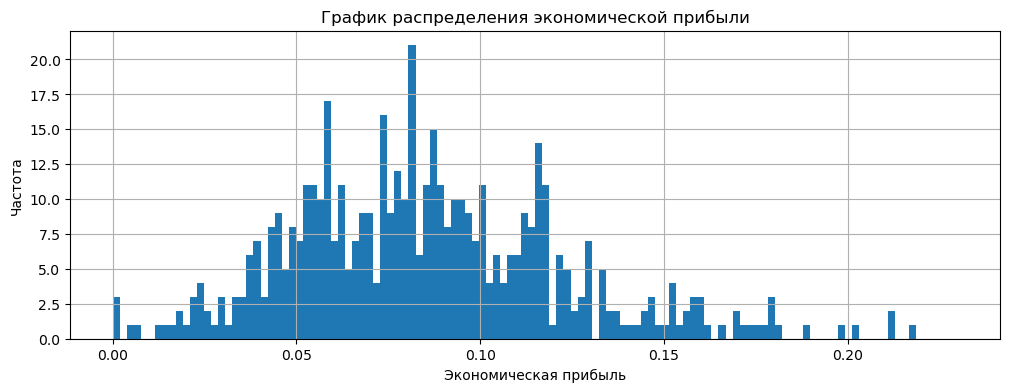

In [7]:
# посмотрим, как распределена экономическая прибыль
ax = loans['profit_%'].hist(bins=120, figsize=(12,4), range=(0, 0.23))
ax.set_title('График распределения экономической прибыли')
ax.set_xlabel('Экономическая прибыль')
ax.set_ylabel('Частота');

In [8]:
loans['profit_%'].quantile(0.714)

0.10003671189082351

Задача состоит в том, чтобы одобрять кредиты с наиболее высокой экономической прибылью. Логично, что займы с нулевой и отрицательной прибылью рассматривать не стоит. Предположим, что самые экономически прибыльные займы, это займы с прибыльностью не менее 10%. Таких займов около 30% от всех займов.

In [9]:
# сегментация займов по уровню прибыльности
loans['good_loan'] = [1 if x >= 0.1 else 0 for x in loans['profit_%']]
loans.head(10)

,loan_issued,rating,comission,earned_int,unpaid,EL,loss,investor_profit,profit,profit_%,good_loan
0,3170000,7,0.0530,211051,862850,0.015,12942.75,198108.25,366118.250,0.115495,1
1,500000,17,0.0650,39518,289518,0.100,28951.80,10566.20,43066.200,0.086132,0
2,11600897,9,0.0450,537680,9567386,0.015,143510.79,394169.21,916209.575,0.078977,0
3,5250000,13,0.0450,233022,2858022,0.015,42870.33,190151.67,426401.670,0.081219,0
4,3000000,8,0.0375,216485,0,0.000,0.00,216485.00,328985.000,0.109662,1
5,4300000,9,0.0600,143563,0,0.000,0.00,143563.00,401563.000,0.093387,0
6,1000000,16,0.0650,69823,741372,0.300,222411.60,-152588.60,-87588.600,-0.087589,0
7,1020000,14,0.0650,22902,964508,0.015,14467.62,8434.38,74734.380,0.073269,0
8,6000000,13,0.0550,223228,4446456,0.015,66696.84,156531.16,486531.160,0.081089,0
9,800000,16,0.0500,51566,451566,0.015,6773.49,44792.51,84792.510,0.105991,1


In [10]:
loans['good_loan'].value_counts(normalize=True, dropna=False)

0    0.714286
1    0.285714
Name: good_loan, dtype: float64

Таким образом был получен таргет, который указывает на экономическую прибыльность займа в 10% и более.

In [11]:
target = loans['good_loan']
target.shape

(532,)

## Отбор факторов (признаков)

In [12]:
# импортируем признаки
features = pd.read_excel('ТЗ аналитик данных.xlsx', usecols='H:AC', skiprows=1)
features

,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,учредитель женщина,Первое ЮЛ,Выручка компании в первый год > 30 млн.,Текущее ЮЛ основано до 30 лет,КИ учредителя < 1 млн,Не знает объем выручки,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
529,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
530,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 22 columns):
 #   Column                                                                            Non-Null Count  Dtype
---  ------                                                                            --------------  -----
 0   учредителю подсказывают / на ВИ другой человек                                    532 non-null    int64
 1   На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы       532 non-null    int64
 2   "Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.         532 non-null    int64
 3   В компании была смена учредителя                                                  532 non-null    int64
 4   учредитель женщина                                                                532 non-null    int64
 5   Первое ЮЛ                                                                         532 non-null    int64
 6   Выручка компании в

Количество строк с признаками соответсвует количеству займов. Всего 22 бинарных признака. Пропусков в столбцах нет.

In [14]:
# конвертируем признаки в формат category
features = features.astype('category')

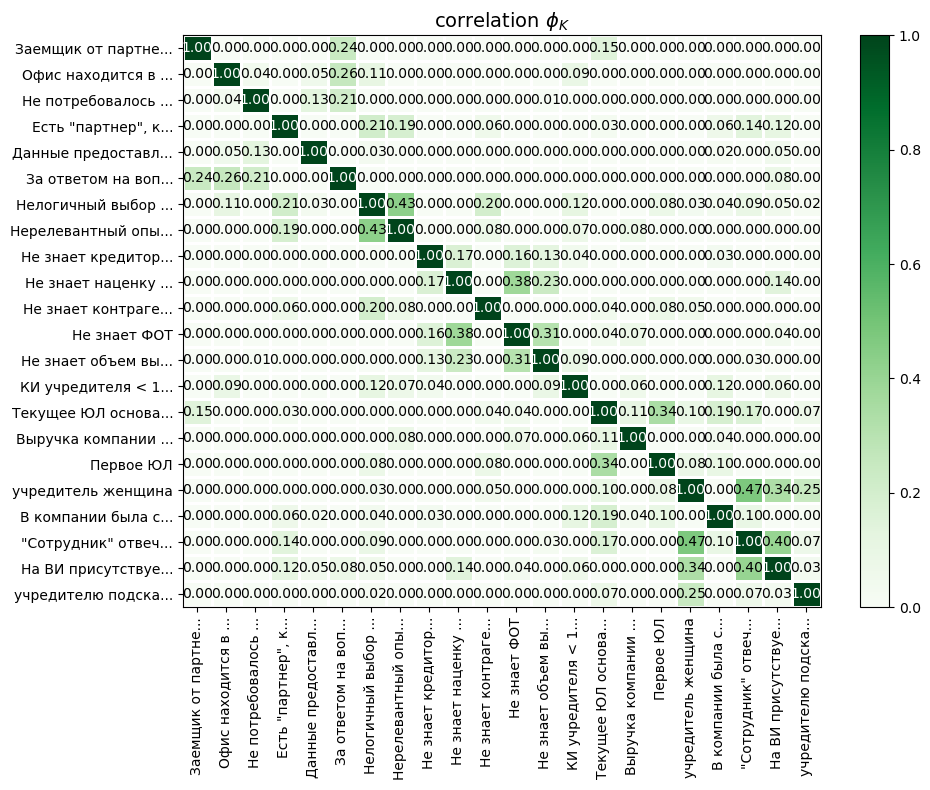

In [15]:
# проверим признаки на мультиколлинеарность, построив корреаляционную матрицу
phik_overview = features.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

Большинство признаков слабо коррелируют между собой либо совсем не коррелируют. Следовательно, отбор признаков не требуется.

## Построение модели выдачи займов

Модель выдачи займов будет строиться на основе таргета, т.е. модель будет классифицировать кредиты на потенциально экономически прибыльные или нет на основе признаков (факторов).

### Деление на выборки

Разделим наш датасет на тренировочную и тестовую выборки в соотношение 0.75/0.25. Выделять валидационную выборку мы не будем, т.к. во время обучения моделей будем применять кросс-валидацию. 

Все признаки являются категориальными и бинарными. Следовательно, кодировка и прочее преобразование признаков не требуется.

In [16]:
# зададим random state в качестве глобальной переменной

random_state = np.random.seed(12345)

In [17]:
# разделим таргет и признаки на семплы
# для сохранения первоначального дисабаланса целевого признака применим стратификацию

features_train, features_test, target_train, target_test = train_test_split(
    features, target,
    test_size=.25,
    stratify=target,
    random_state=random_state)

print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(399, 22) (133, 22)
(399,) (133,)


### Логистическая регрессия

In [18]:
# зададим модель
model = LogisticRegression(random_state=random_state, class_weight='balanced')

# обучим модель через кросс-валидацию
scores = cross_val_score(model, features_train, target_train, cv=3, scoring='roc_auc')

# усредним полученную метрику
lr_score = scores.mean()
lr_score

0.6649584487534627

### Случайный лес

In [19]:
%%time

# выберем модель
model = RandomForestClassifier(
    random_state=random_state, class_weight='balanced')

# настроим параметры модели для перебора
params = {'max_depth': np.arange(5, 25),
          'n_estimators': np.arange(100, 251, 10)}


# передадим параметры модели в GridSearchCV (gs - grid search, rfc - random forest classifier)
gs_rfc = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=3)

# обучим модель
gs_rfc.fit(features_train, target_train)

# выведем лучшие параметры
gs_rfc.best_params_

CPU times: user 1min 8s, sys: 460 ms, total: 1min 8s
Wall time: 1min 8s


{'max_depth': 5, 'n_estimators': 180}

In [20]:
# выведем лучшую метрику
gs_rfc.best_score_

0.6794552169898429

### Градиентный бустинг

In [21]:
# преобразуем названия признаков, чтобы избежать ошибок со стороны библиотеки LightGBM
features_train_ = features_train.rename(columns = lambda x:re.sub('[^А-Яа-я0-9_]+', ' ', x))
features_train_.dtypes

учредителю подсказывают на ВИ другой человек                                       category
На ВИ присутствует сотрудник в тч за кадром который отвечает на вопросы            category
 Сотрудник отвечает на вопросы ГД учредитель молчит или отвечает редко             category
В компании была смена учредителя                                                   category
учредитель женщина                                                                 category
Первое ЮЛ                                                                          category
Выручка компании в первый год 30 млн                                               category
Текущее ЮЛ основано до 30 лет                                                      category
КИ учредителя 1 млн                                                                category
Не знает объем выручки                                                             category
Не знает ФОТ                                                                    

In [22]:
%%time

# зададим модель
model = lgb.LGBMClassifier(
    random_seed=random_state, boosting_type='gbdt', verbosity=-1, class_weight='balanced')

# зададим параметры модели для перебора
params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': np.arange(2, 25),
    'n_estimators': np.arange(100, 251, 10)
}
    
# передадим параметры модели в GridSearchCV
gs_lgb = GridSearchCV(model, param_grid=params, cv=3, scoring='roc_auc')

# обучим модель
gs_lgb.fit(features_train_, target_train)
    
# выведем лучшие параметры
gs_lgb.best_params_

CPU times: user 18min 8s, sys: 3min 24s, total: 21min 33s
Wall time: 2min 52s


{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 250}

In [23]:
# выведем score модели
gs_lgb.best_score_

0.607202216066482

### Константная модель

In [24]:
# зададим модель
model = DummyClassifier(strategy='most_frequent', random_state=random_state)

# Обучим модель через кросс-валидацию. Выходная метрика - ROC-AUC. Количество подвыборок - 3.
scores = cross_val_score(model, features_train, target_train, cv=3, scoring='roc_auc')

# усредним полученную метрику
dc_score = scores.mean()
dc_score

0.5

Все построенные модели являются адекватными, т.к. их метрики выше, чем у константной модели.

### Выбор модели

Сравним построенные модели

In [25]:
results = pd.DataFrame(columns=['model', 'parameters', 'score'])
results['model'] = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']
results['score'] = [lr_score, gs_rfc.best_score_, gs_lgb.best_score_]
results['parameters'] = ['-', gs_rfc.best_params_, gs_lgb.best_params_]
results.sort_values(by='score', ascending=False)

,model,parameters,score
1,RandomForestClassifier,"{'max_depth': 5, 'n_estimators': 180}",0.679455
0,LogisticRegression,-,0.664958
2,LGBMClassifier,"{'learning_rate': 0.005, 'max_depth': 2, 'n_es...",0.607202


Лучшей моделью является модель случайного леса, которае немного превосходит логистическую регрессию. Модель с градиентным бустингом показала худший результат, т.к. данная модель плохо работает только с бинарными переменными.

### Тестирование модели

In [26]:
# зададим модель
model = RandomForestClassifier(
    random_state=random_state,
    class_weight='balanced',
    max_depth=5,
    n_estimators=180
)

# обучение модели
model.fit(features_train, target_train)

# расчёт метрики ROC-AUC на тестовой выборке
roc_auc_score(target_test, model.predict_proba(features_test)[:,1])

0.6222991689750692

Качество модели несколько упало на тестовой выборке

In [27]:
# функция для построения ROC-кривой

def roc_graph(target, probabilities_one):
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange") 
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая") 
    plt.grid()
    plt.show()

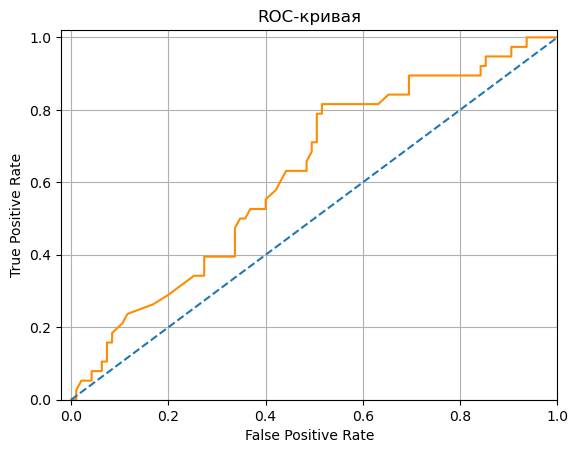

In [30]:
# построим ROC-кривую

roc_graph(target_test, model.predict_proba(features_test)[:,1])

In [31]:
# расчёт метрики accuracy на тестовой выборке
accuracy_score(target_test, model.predict(features_test))

0.5789473684210527

In [32]:
# вывод confusion matrix на тестовой выборке
confusion_matrix(target_test, model.predict(features_test), normalize='true')

array([[0.55789474, 0.44210526],
       [0.36842105, 0.63157895]])

**Вывод:** модель случайного леса показало качество на тестовой модели ниже, чем на обучающей выборке. Возможно это связано с малым количество данных. Модель правильно угадывает высоко-доходные займы в 56% случаев и в 63% остальные займы. В 44% случаев модель неправильно предсказывает высоко-доходные займы, что может привести к снижению экономической прибыли.

### Анализ важности признаков

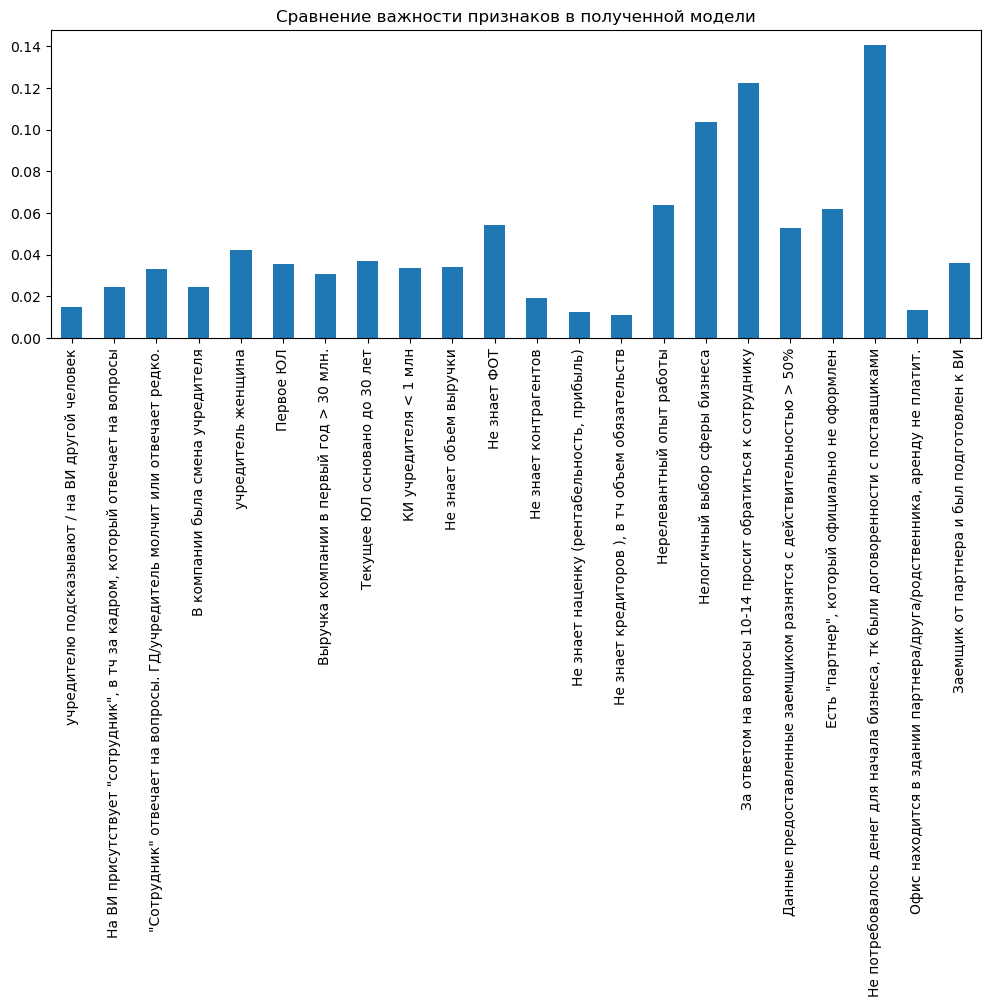

In [34]:
importances = pd.Series(gs_rfc.best_estimator_.feature_importances_, index=features.columns)

importances.plot(
    kind='bar',
    figsize=(12, 4),
    title='Сравнение важности признаков в полученной модели'
);

Наиболее важными признаками в модели являются:
- Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками;
- За ответом на вопросы 10-14 просит обратиться к сотруднику;
- Нелогичный выбор сферы бизнеса.

Следубщие признаки являются наименее важными, их в целом можно исключить из модели:
- Не знает кредиторов, в тч объем обязательств;
- Не знает наценку (рентабельность, прибыль);
- Офис находится в здании партнера друга родственника аренду не платит;
- учредителю подсказывают / на ВИ другой человек;
- Не знает контрагентов.

## Выводы

Для исследования были предоставлены финансовые характеристики займа и факторы, похожие на анкету.

После предобработки данных были выполнены следующие шаги:
1. Расчёт экономической прибыли займов;
2. Исследование распределения данного признака;
3. Разделение займов на высоко-доходные и остальные.

Разделение займов также является таргетом для модели: выдавать займ, т.к. оно высоко-доходный, или не выдавать, т.к. таковым он не является.

Далее были выполнены следующие шаги для построения модели выдачи займов:
1. Проверка признаков на мультиколлинеарность;
2. Разбиение семпла на тренировочную и тестовую выборки;
3. Построение моделей логистической регрессии, случайного леса и градиентного бустинга с выбором оптимальных параметров;
4. Построение константной модели и проверка моделей на адекватность;
5. Выбор лучшей модели;
6. Тестирование лучшей модели;
7. Анализ важности признаков.

Лучшей моделью оказалась модель случайного леса с метриками ROC-AUC=0.62 и accuracy=0.58. Данные метрики являются довольно низкими. Далеко не все признаки в модели оказались важными.

Необходимо предпринять следующие шаги, чтобы улучшить качество модели:
1. Увеличить объём данных. Предоставленный семпл слишком мал для построения адекватных моделей;
2. Включить в признаковое пространство другие признаки (осбоенно количественные), в том числе признаки характеристики кредита;
3. Исключить из модели признаки, не оказывающие никакого влияния;
4. Использовать не только бинарные категориальные признаки.

В признакове пространство можно включить следующие признаки:
- размер займа;
- возраст руководителя;
- возможные предыдущие дефолты при работе руководителя;
- объём выручки компании;
- налоговая нагрузка;
- регион;
- организационно-правовая форма;
- сфера работы компании;
- есть ли штрафы и т.д.

Далеко не все предоставленные факторы влияют на доходность от кредита, а многие из них могут быть субъективными, например, если собственник не знает рентабельность бизнеса, это не значит что бухгалтер не знает данный показатель. Даже если собственник не знает расчёта рентабельности бизнеса это не значит что бизнес не рентабельный и он не может своеременно платить по обязательствам. Нахождение офиса в здании партнёра/друга слабо коррелирует с прибыльностью займа: незначительные расходы на аренду могут быть связаны с тем, что большая часть сотрудников работет удалённо либо компания вовсе не имеет офиса. Набор факторов/признаков следует пересмотреть.